In [1]:
import sympy as sym
import numpy as np
from sympy import symbols, Eq
from sympy.abc import alpha, beta, theta, sigma, rho, phi, mu, nu, kappa
import matplotlib.pyplot as plt

In [4]:
a,b,c= symbols('a,b,c')
eq = Eq(a+b,c)
eq

Eq(a + b, c)

In [16]:
def f(vars, eq):
    d={i:symbols(i) for i in vars.split(',')}
    eq=Eq(*[eval(i,d) for i in eq.split('=')])    
    return eq

f(vars ='a,b,c',eq='a+b=c')

Eq(a + b, c)

# Sims 1999

$$\Gamma_0 y_t=\Gamma_1 y_{t-1}+C+\Psi z_t+\Pi\eta_t$$

In [243]:
def gensys(Gamma0:sym.Matrix, Gamma1:sym.Matrix, 
                 C:sym.Matrix=None, Psi:sym.Matrix=None, 
                 Eta:sym.Matrix=None,
                 out:str = 'np.array')->tuple:
    return_Theta_c = True
    if C is None:
        C, return_Theta_c = sym.zeros(Gamma0.rows,1), False
    if Eta is None:
        Eta = sym.zeros(Gamma0.rows,1)
    Gamma0_inv=Gamma0.inv()
    Gamma1, C, Psi, Eta = Gamma0_inv@Gamma1, Gamma0_inv@C, Gamma0_inv@Psi, Gamma0_inv@Eta 
    P, Lambda = Gamma1.diagonalize()
    ind = list(np.argsort(np.abs(np.diag(np.abs(Lambda)))))
    Lambda = sym.diag(*[Lambda[i,i] for i in ind])
    P=P.permute_cols(ind)  
    #P*Lambda*P.inv()=Gamma1 check 
    P_inv = P.inv()
    n_s = len([Lambda[i,i] for i in range(Lambda.rows) if np.abs(Lambda[i,i])>1])
    n_u = Lambda.rows-n_s
    Lambda_S=Lambda[:n_s,:n_s]
    Lambda_U=Lambda[n_s:,n_s:]
    Theta_1 = P[:,:n_s]*Lambda_S*P_inv[:n_s,:]
    Theta_c = (P[:,:n_s]*P_inv[:n_s,:]+P[:,n_s:]*(sym.eye(n_u)-Lambda_U)*P_inv[n_s:,:])*C
    Phi = P_inv[:n_s,:]*Eta*(P_inv[n_s:,:]*Eta).inv()
    Theta_z = (P[:,:n_s]*P_inv[:n_s,:]-P[:,:n_s]*Phi*P_inv[n_s:,:])*Psi
    Theta_1 = Theta_1.as_real_imag()[0]
    Theta_c = Theta_c.as_real_imag()[0]
    Theta_z = Theta_z.as_real_imag()[0]
    if out=='np.array':
        Theta_1 = np.array(Theta_1).astype(np.float64)
        Theta_c = np.array(Theta_c).astype(np.float64)
        Theta_z = np.array(Theta_z).astype(np.float64) 
    if return_Theta_c:
        return Theta_1, Theta_c, Theta_z
    else:
        return Theta_1, Theta_z

In [244]:
def gensys(Gamma0:sym.Matrix, Gamma1:sym.Matrix, 
                 C:sym.Matrix=None, Psi:sym.Matrix=None, 
                 Eta:sym.Matrix=None,
                 out:str = 'np.array')->tuple:
    return_Theta_c = True
    if C is None:
        C, return_Theta_c = sym.zeros(Gamma0.rows,1), False
    if Eta is None:
        Eta = sym.zeros(Gamma0.rows,1)
    Gamma0_inv=Gamma0.inv()
    Gamma1, C, Psi, Eta = Gamma0_inv@Gamma1, Gamma0_inv@C, Gamma0_inv@Psi, Gamma0_inv@Eta 
    P, Lambda = Gamma1.diagonalize()
    ind = list(np.argsort(np.abs(np.diag(np.abs(Lambda)))))
    Lambda = sym.diag(*[Lambda[i,i] for i in ind])
    n_s = len([Lambda[i,i] for i in range(Lambda.rows) if np.abs(Lambda[i,i])<1])
    n_u = Lambda.rows-n_s
    
    P=P.permute_cols(ind)  
    P = np.array(P).astype(np.complex128) 
    P_inv = np.linalg.inv(P)

    Lambda_S=Lambda[:n_s,:n_s]
    Lambda_U=Lambda[n_s:,n_s:]
    Theta_1 = P[:,:n_s]@Lambda_S@P_inv[:n_s,:]
    Theta_c = (P[:,:n_s]@P_inv[:n_s,:]+P[:,n_s:]@(sym.eye(n_u)-Lambda_U)@P_inv[n_s:,:])@C
    Phi = P_inv[:n_s,:]@Eta@(P_inv[n_s:,:]@Eta).inv()
    Theta_z = (P[:,:n_s]@P_inv[:n_s,:]-P[:,:n_s]@Phi@P_inv[n_s:,:])@Psi
    Theta_1 = np.real(np.array(Theta_1).astype(np.complex64))
    Theta_c = np.real(np.array(Theta_c).astype(np.complex64))
    Theta_z = np.real(np.array(Theta_z).astype(np.complex64)) 
    #Theta_1 = Theta_1.as_real_imag()[0]
    #Theta_c = Theta_c.as_real_imag()[0]
    #Theta_z = Theta_z.as_real_imag()[0]
    #if out=='np.array':
    #    Theta_1 = np.array(Theta_1).astype(np.float64)
    #    Theta_c = np.array(Theta_c).astype(np.float64)
    #    Theta_z = np.array(Theta_z).astype(np.float64) 
    if return_Theta_c:
        return Theta_1, Theta_c, Theta_z
    else:
        return Theta_1, Theta_z

In [245]:
def get_matrices(equations, var, var_, z, eta):
    Gamma0,_ = sym.linear_eq_to_matrix([is_curve,nkpc, exp_y, exp_pi, v_ar], var)
    Gamma1,_ = sym.linear_eq_to_matrix(_,var_)
    Psi, _ = sym.linear_eq_to_matrix(_, z)
    Eta, C = sym.linear_eq_to_matrix(_, eta)
    Psi = -Psi
    C = -C
    return Gamma0, Gamma1, Psi, Eta, C

In [26]:
class Gensys:
    def __init__(self,parameters:str, variables:str, shocks:str,equations):
        ''' 
        variables: str
        string of variables separated by commas.
        '''
        self.vars = {v:symbols(v) for v in variables.replace(" ", "").split(',')}
        self.n_var = len(self.vars)
        self.shocks = {s:symbols(s) for s in shocks.replace(" ", "").split(',')}
        self.n_shocks = len(self.shocks)
        self.parameters = {p:symbols(p) for p in parameters.replace(" ", "").split(',')}
        self.symbolic_system = None
        self.numeric_system = None
        self.matrix_solution = None
        self.calibration = None
        #self.equations = {Eq(*[eval(i) for i in eq.split('=')]) for eq in equations}
        pass




    def get_matrices(self,equations, var, var_, z, eta):
        Gamma0,_ = sym.linear_eq_to_matrix(equations, var)
        Gamma1,_ = sym.linear_eq_to_matrix(_,var_)
        Psi, _ = sym.linear_eq_to_matrix(_, z)
        Eta, C = sym.linear_eq_to_matrix(_, eta)
        Psi = -Psi
        C = -C
        self.symbolic_system={'Gamma0':Gamma0, 'Gamma1':Gamma1,'Psi':Psi, 'Eta':Eta, 'C':C}
        pass
        
    def calibrate(self,calibration):
        self.calibration = calibration
        Gamma0 = self.symbolic_system['Gamma0'].subs(calibration)
        Gamma1 = self.symbolic_system['Gamma1'].subs(calibration)
        Psi = self.symbolic_system['Psi'].subs(calibration)
        C = self.symbolic_system['C'].subs(calibration)
        self.numeric_system = {'Gamma0':Gamma0, 'Gamma1':Gamma1,'Psi':Psi, 'Eta':Eta, 'C':C}
        pass

    def solve(self):
        return self._solve(**self.numeric_system)
     
    def _solve(self, Gamma0, Gamma1, Psi, Eta, C):
        Gamma0_inv=Gamma0.inv()
        Gamma1, C, Psi, Eta = Gamma0_inv@Gamma1, Gamma0_inv@C, Gamma0_inv@Psi, Gamma0_inv@Eta 
        P, Lambda = Gamma1.diagonalize()
        ind = list(np.argsort(np.abs(np.diag(np.abs(Lambda)))))
        Lambda = sym.diag(*[Lambda[i,i] for i in ind])
        n_s = len([Lambda[i,i] for i in range(Lambda.rows) if np.abs(Lambda[i,i])<1])
        n_u = Lambda.rows-n_s        
        P=P.permute_cols(ind)  
        P = np.array(P).astype(np.complex128) 
        P_inv = np.linalg.inv(P)
        Lambda_S=Lambda[:n_s,:n_s]
        Lambda_U=Lambda[n_s:,n_s:]
        Theta_1 = P[:,:n_s]@Lambda_S@P_inv[:n_s,:]
        Theta_c = (P[:,:n_s]@P_inv[:n_s,:]+P[:,n_s:]@(sym.eye(n_u)-Lambda_U)@P_inv[n_s:,:])@C
        Phi = P_inv[:n_s,:]@Eta@(P_inv[n_s:,:]@Eta).inv()
        Theta_z = (P[:,:n_s]@P_inv[:n_s,:]-P[:,:n_s]@Phi@P_inv[n_s:,:])@Psi
        Theta_1 = np.real(np.array(Theta_1).astype(np.complex64))
        Theta_c = np.real(np.array(Theta_c).astype(np.complex64))
        Theta_z = np.real(np.array(Theta_z).astype(np.complex64)) 
        self.matrix_solution={'Theta_1':Theta_1,'Theta_c':Theta_c, 'Theta_z':Theta_z}
    
    def impulse_response(self, z:np.array, T:int = 25):
        '''
        z: initial shock
        '''
        n_var = self.n_var
        Theta_1 = self.matrix_solution['Theta_1']
        Theta_c = self.matrix_solution['Theta_c']
        Theta_z = self.matrix_solution['Theta_z']
        z_t = np.zeros((T,self.n_shocks))
        z_t[:,0] = z
        y_t = np.zeros((T,n_var))
        t=np.arange(0,T)
        for i in range(1,T):
            y_t[i]=(Theta_1@y_t[[i-1]].T+Theta_z@z_t[[i]].T).flatten()

        max_cols=3
        fig,ax=plt.subplots(nrows=(n_var-1)//max_cols+1,ncols=min(n_var,max_cols), figsize=(10,10))
        for i in range(n_var):
            ax[i//max_cols,i%max_cols].plot(t,y_t[:,i])
        fig.show()

In [27]:
g=Gensys('kappa','y, pi','eps_p',0)

In [25]:
g.vars['y']

y

In [369]:
E_y, E_pi, y_, pi_ = symbols('E_{t-1}y_t,E_{t-1}\pi^p_t, y_{t-1}, \pi_{t-1}')
Ey1, Epi1, y, pi = symbols('E_ty_{t+1},E_t\pi^p_{t+1}, y_t, \pi_t')
phi_y, phi_p =symbols('\phi_y, \phi_p')
lam = symbols('\lambda')
eta_y, eta_pi = symbols('\eta_y, \eta_{\pi}')
v, v_ = symbols('v_t, v_{t-1}')
rho_v = symbols('\\rho_v')
eps_v = symbols('\epsilon_v')

In [370]:
i = rho+phi_p*pi+phi_y*y+v

In [371]:
equations = [
 'y=Ey1-1/sigma*(rho+phi_p*pi+phi_y*y+v-Epi1-rho)',
 'pi=beta*Epi1+kappa*y',
 'y=E_y+eta_y',
 'pi=E_pi+eta_pi',
 'v=rho_v*v_+eps_v'
]

In [372]:
rhs,lhs = equations[0].split('=')

In [373]:
equations[0].split('=')

['y', 'Ey1-1/sigma*(rho+phi_p*pi+phi_y*y+v-Epi1-rho)']

In [374]:
[i for i in equations[0].split('=')]

['y', 'Ey1-1/sigma*(rho+phi_p*pi+phi_y*y+v-Epi1-rho)']

In [375]:
Eq(*[eval(i) for i in equations[0].split('=')])

Eq(y_t, E_ty_{t+1} - (-E_t\pi^p_{t+1} + \phi_p*\pi_t + \phi_y*y_t + v_t)/sigma)

In [376]:
[Eq(*[eval(i) for i in eq.split('=')]) for eq in equations]

[Eq(y_t, E_ty_{t+1} - (-E_t\pi^p_{t+1} + \phi_p*\pi_t + \phi_y*y_t + v_t)/sigma),
 Eq(\pi_t, E_t\pi^p_{t+1}*beta + kappa*y_t),
 Eq(y_t, E_{t-1}y_t + \eta_y),
 Eq(\pi_t, E_{t-1}\pi^p_t + \eta_{\pi}),
 Eq(v_t, \epsilon_v + \rho_v*v_{t-1})]

In [377]:
Eq(eval(rhs),eval(lhs))

Eq(y_t, E_ty_{t+1} - (-E_t\pi^p_{t+1} + \phi_p*\pi_t + \phi_y*y_t + v_t)/sigma)

In [378]:
Eq(rhs,lhs)

SympifyError: SympifyError: 'y'

In [379]:
parameters = 'phi_y phi_p lam eta_y eta_pi rho_v beta sigma rho kappa'
variables = 'Ey1 Epi1 y pi v'
shocks = 'eps_v'
Gensys(parameters, variables, shocks,equations)

## Galí Sticky Prices

**Define simbolic variables**

In [28]:
E_y, E_pi, y_, pi_ = symbols('E_{t-1}y_t,E_{t-1}\pi^p_t, y_{t-1}, \pi_{t-1}')
Ey1, Epi1, y, pi = symbols('E_ty_{t+1},E_t\pi^p_{t+1}, y_t, \pi_t')
phi_y, phi_p =symbols('\phi_y, \phi_p')
lam = symbols('\lambda')
eta_y, eta_pi = symbols('\eta_y, \eta_{\pi}')
v, v_ = symbols('v_t, v_{t-1}')
rho_v = symbols('\\rho_v')
eps_v = symbols('\epsilon_v')

**Define static equations**

In [29]:
i = rho+phi_p*pi+phi_y*y+v

**Define system equations**

In [30]:
is_curve = Eq(y, Ey1-1/sigma*(i-Epi1-rho))
nkpc = Eq(pi, beta*Epi1+kappa*y)
exp_y = Eq(y, E_y+eta_y)
exp_pi = Eq(pi, E_pi+eta_pi)
v_ar=Eq(v, rho_v*v_+eps_v)

**Define Variables, lags, shocks and expectation errors**

In [31]:
var  = Ey1, Epi1, y, pi, v
var_ = E_y, E_pi, y_, pi_, v_
z = eps_v,
eta = eta_y, eta_pi

**Write the system in matrix form**

In [32]:
Gamma0,Gamma1, Psi, Eta, C =  get_matrices([is_curve,nkpc, exp_y, exp_pi, v_ar], var, var_, z, eta)

NameError: name 'get_matrices' is not defined

In [385]:
g=Gensys(0,0,0,0)
g.matrices = g.get_matrices([is_curve,nkpc, exp_y, exp_pi, v_ar], var, var_, z, eta)

**Calibrate numerically**

In [386]:
calibration={'beta':0.99, 'phi':5, 'alpha':1/4, 'eps':9,
             '\phi_p':1.5, '\phi_y':0.5/4,'\\rho_v':0.5,
             'sigma':1,
              'theta':3/4}
calibration['Theta']=(1-calibration['alpha'])/(1-calibration['alpha']+calibration['alpha']*calibration['eps'])
calibration['lambda']=(1-calibration['theta'])*(1-calibration['beta']*calibration['theta'])/calibration['theta']*calibration['Theta']
calibration['kappa']=calibration['lambda']*(calibration['sigma']+(calibration['phi']+calibration['alpha'])/(1-calibration['alpha']))

Gamma0 = Gamma0.subs(calibration)
Gamma1 = Gamma1.subs(calibration)
Psi = Psi.subs(calibration)

In [387]:
g.calibrate(calibration)

In [388]:
g.solve()

C:\Users\MBBar\AppData\Local\Temp/ipykernel_3648/3162096931.py:78: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


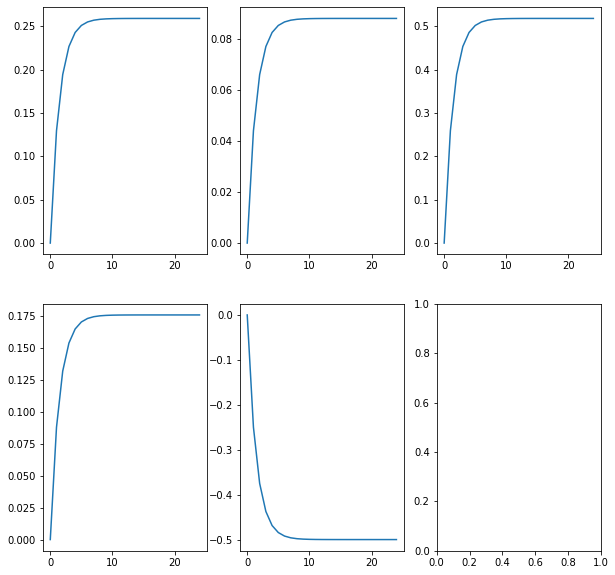

In [389]:
g.impulse_response(z=np.array(-0.25))

**Solve the system**

In [119]:
Theta_1, Theta_z = gensys(Gamma0=Gamma0, Gamma1=Gamma1, Psi=Psi, Eta=Eta)

**Impulse Responses**

In [121]:
T=15
z_t = np.zeros((T,len(z)))
y_t = np.zeros((T,len(var)))
y_ = np.array([0,0,0,0,0])
t=np.arange(0,T)
y_t[0] = y_
z_t[:,0] = 0.25
for i in range(1,T):
    y_t[i]=(Theta_1@y_t[[i-1]].T+Theta_z@z_t[[i]].T).flatten()

C:\Users\MBBar\AppData\Local\Temp/ipykernel_2592/2350625629.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


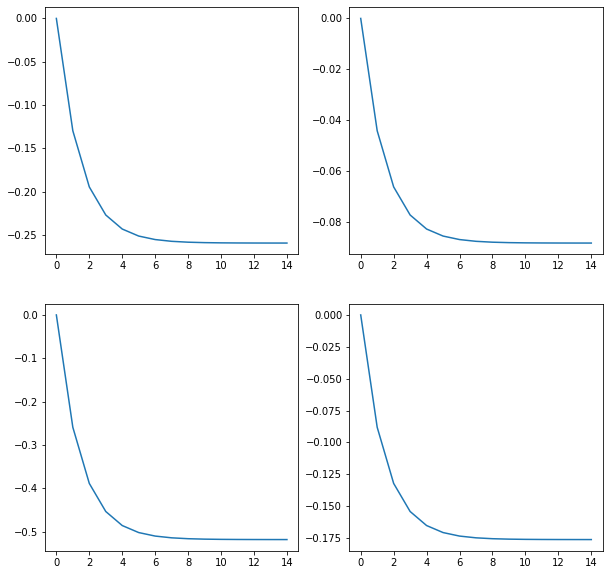

In [124]:
fig,ax=plt.subplots(nrows=2,ncols=2, figsize=(10,10))
ax[0,0].plot(t,y_t[:,0])
ax[0,1].plot(t,y_t[:,1])
ax[1,0].plot(t,y_t[:,2])
ax[1,1].plot(t,y_t[:,3])
fig.show()

## Sticky wages (Chapter 6)

In [ ]:
calibration={'beta':0.99, 'phi':5, 'alpha':1/4, 'eps_p':9,
             '\phi_p':1.5,'\phi_w':0.125, '\phi_y':0.5/4,
             'eps_w':4.5, 'sigma':1,
              'theta_p':3/4,'theta_w':3/4}

In [ ]:
class StickyWageNK():
    def __init__(self):
        self.calibration = None
    def calibrate(self, calibration: dict):
        theta_w = calibration['theta_w']
        theta_p = calibration['theta_p']
        beta = calibration['beta']
        phi = calibration['phi']
        eps_w = calibration['eps_w']
        eps_p = calibration['eps_w']
        alpha = calibration['alpha']
        sigma = calibration['sigma']
        calibration['\lambda_w']=(1-theta_w)*(1-beta*theta_w)/(theta_w*(1+eps_w*phi))
        calibration['\lambda_p']=(1-theta_p)*(1-beta*theta_p)/(theta_p)*(1-alpha)/(1-alpha+alpha*eps_p)
        calibration['chi_p'] = alpha*calibration['\lambda_p']/(1-alpha)
        calibration['chi_w'] = calibration['\lambda_w']*(sigma+phi/(1-alpha))
        self.calibration = calibration

In [ ]:
economy=StickyWageNK()
economy.calibrate(calibration)

In [ ]:
calibration = economy.calibration

In [ ]:
Gamma0 = Gamma0.subs(calibration)
Gamma1 = Gamma1.subs(calibration)
C = C.subs(calibration)
Psi = Psi.subs(calibration)

In [ ]:
Theta_1, Theta_c, Theta_z = solve_system(Gamma0, Gamma1, C, Psi, Eta)

**Solve Impulse Response**

## Galí Sticky wages and sticky prices

In [2]:
y,pi_p, pi_w, w_ = symbols('y_t,\pi^p_t,\pi_t^w,\omega_{t-1}')
y1,pi_p1, pi_w1, w = symbols('E_ty_{t+1},E_t\pi^p_{t+1},E_t\pi_{t+1}^w,\omega_t')

phi_y, phi_p, phi_w=symbols('\phi_y, \phi_p, \phi_w')
lam_p, lam_w = symbols('\lambda_p, \lambda_w')
chi_p, chi_w = symbols('chi_p, chi_w')

v, Delta_w = symbols('v, \Delta\omega_t^n')

In [3]:
i = rho+phi_p*pi_p+phi_w*pi_w+phi_y*y+v

In [4]:
is_curve = Eq(y, y1-1/sigma*(i-pi_p1-rho))
real_wage = Eq(w, w_+pi_w-pi_p-Delta_w)
price_nkpc = Eq(pi_w, beta*pi_w1+chi_w*y-lam_w*w)
wage_nkpc = Eq(pi_p, beta*pi_p1+chi_p*y+lam_p*w)

In [5]:
var  = y1,pi_p1, pi_w1, w
var_ = y,pi_p, pi_w, w_
z = v, Delta_w

In [6]:
Gamma0,_ = sym.linear_eq_to_matrix([is_curve,real_wage,price_nkpc,wage_nkpc], var)
Gamma1,_ = sym.linear_eq_to_matrix(_,var_)
Psi, C = sym.linear_eq_to_matrix(_, z)
Eta = sym.Matrix([[1,0,0,0],[0,0,1,0],[0,0,0,1]]).T

In [7]:
calibration={'beta':0.99, 'phi':5, 'alpha':1/4, 'eps_p':9,
             '\phi_p':1.5,'\phi_w':0.125, '\phi_y':0.5/4,
             'eps_w':4.5, 'sigma':1,
              'theta_p':3/4,'theta_w':3/4}

In [8]:
class StickyWageNK():
    def __init__(self):
        self.calibration = None
    def calibrate(self, calibration: dict):
        theta_w = calibration['theta_w']
        theta_p = calibration['theta_p']
        beta = calibration['beta']
        phi = calibration['phi']
        eps_w = calibration['eps_w']
        eps_p = calibration['eps_w']
        alpha = calibration['alpha']
        sigma = calibration['sigma']
        calibration['\lambda_w']=(1-theta_w)*(1-beta*theta_w)/(theta_w*(1+eps_w*phi))
        calibration['\lambda_p']=(1-theta_p)*(1-beta*theta_p)/(theta_p)*(1-alpha)/(1-alpha+alpha*eps_p)
        calibration['chi_p'] = alpha*calibration['\lambda_p']/(1-alpha)
        calibration['chi_w'] = calibration['\lambda_w']*(sigma+phi/(1-alpha))
        self.calibration = calibration

In [9]:
economy=StickyWageNK()
economy.calibrate(calibration)

In [10]:
calibration = economy.calibration

In [11]:
Gamma0 = Gamma0.subs(calibration)
Gamma1 = Gamma1.subs(calibration)
C = C.subs(calibration)
Psi = Psi.subs(calibration)

In [12]:
def solve_system(Gamma0:sym.Matrix, Gamma1:sym.Matrix, C:sym.Matrix, Psi:sym.Matrix, Eta:sym.Matrix,
                 out:str = 'np.array')->tuple:
    if np.abs(Gamma0.det())<1e-10:
        raise ValueError('Gamma0 is not invertible')
    Gamma0_inv=Gamma0.inv()
    Gamma1, C, Psi, Eta = Gamma0_inv@Gamma1, Gamma0_inv@C, Gamma0_inv@Psi, Gamma0_inv@Eta 
    P, Lambda = Gamma1.diagonalize()
    ind = list(np.argsort(np.abs(np.diag(np.abs(Lambda)))))
    Lambda = sym.diag(*[Lambda[i,i] for i in ind])
    P=P.permute_cols(ind)
    P_inv = P.inv()
    n_s = len([Lambda[i,i] for i in range(Lambda.rows) if np.abs(Lambda[i,i])<1])
    n_u = Lambda.rows-n_s
    Lambda_S=Lambda[:n_s,:n_s]
    Lambda_U=Lambda[n_s:,n_s:]
    Theta_1 = P[:,:n_s]*Lambda_S*P_inv[:n_s,:]
    Theta_c = (P[:,:n_s]*P_inv[:n_s,:]+P[:,n_s:]*(sym.eye(n_u)-Lambda_U)*P_inv[n_s:,:])*C
    Phi = P_inv[:n_s,:]*Eta*(P_inv[n_s:,:]*Eta).inv()
    Theta_z = (P[:,:n_s]*P_inv[:n_s,:]-P[:,:n_s]*Phi*P_inv[n_s:,:])*Psi
    Theta_1 = Theta_1.as_real_imag()[0]
    Theta_c = Theta_c.as_real_imag()[0]
    Theta_z = Theta_z.as_real_imag()[0]
    if out=='np.array':
        Theta_1 = np.array(Theta_1).astype(np.float64)
        Theta_c = np.array(Theta_c).astype(np.float64)
        Theta_z = np.array(Theta_z).astype(np.float64)

    return Theta_1, Theta_c, Theta_z

In [13]:
Theta_1, Theta_c, Theta_z = solve_system(Gamma0, Gamma1, C, Psi, Eta)

**Solve Impulse Response**

In [15]:
T=15

In [16]:
z_t = np.zeros((T,len(z)))
y_t = np.zeros((T,len(var)))

In [24]:
y_ = np.array([0,0,0,0])
rho_v = 0.5
t=np.arange(0,T)
v=0.25*np.exp(-rho_v*t)

In [25]:
y_t[0] = y_
z_t[:,0] = v

In [51]:
Theta_z

array([[ 0.00000000e+00, -2.65591105e-01],
       [ 3.46944695e-18,  1.29902103e-01],
       [ 0.00000000e+00, -5.41866996e-02],
       [ 2.77555756e-17,  1.00000000e+00]])

In [50]:
Theta_z@z_t[[1]].T

array([[0.00000000e+00],
       [5.26081487e-19],
       [0.00000000e+00],
       [4.20865190e-18]])

In [40]:

output = np.zeros((T,len(y_)))
output[0]=y_

for i in range(1,T):
    y_t[i]=(Theta_1@y_t[[i-1]].T+Theta_c+Theta_z@z_t[[i]].T).flatten()

C:\Users\MBBar\AppData\Local\Temp/ipykernel_18856/2350625629.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


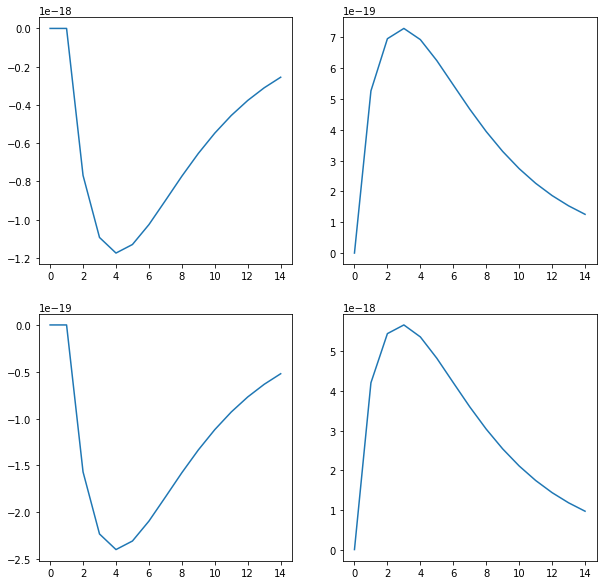

In [48]:
fig,ax=plt.subplots(nrows=2,ncols=2, figsize=(10,10))
ax[0,0].plot(t,y_t[:,0])
ax[0,1].plot(t,y_t[:,1])
ax[1,0].plot(t,y_t[:,2])
ax[1,1].plot(t,y_t[:,3])
fig.show()